In [1]:
import sqlite3
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns


from tqdm import tqdm
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from scipy.stats import ttest_ind
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import ipywidgets as widgets
from IPython.display import display

### 1. Доступ к базе данных

In [3]:
conn = sqlite3.connect('shop_database.db')

In [4]:
cursor = conn.cursor()

In [5]:
table_query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor.execute(table_query)
tables = cursor.fetchall()

In [6]:
for table in tables:
    print(table[0])

purchases
personal_data_coeffs
personal_data


In [7]:
select_query = "SELECT * FROM purchases;"
cursor.execute(select_query)
data = cursor.fetchall()

In [8]:
csv_file_path = 'purchases.csv'

In [13]:
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Заголовки столбцов
    column_names = [description[0] for description in cursor.description]
    csv_writer.writerow(column_names)
    # Строки данных
    csv_writer.writerows(data)

print(f"Данные сохранены в {csv_file_path}")

Данные сохранены в purchases.csv


In [14]:
select_query = "SELECT * FROM personal_data_coeffs;"
cursor.execute(select_query)
data = cursor.fetchall()

In [15]:
csv_file_path = 'personal_data_coeffs.csv'

In [16]:
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Заголовки столбцов 
    column_names = [description[0] for description in cursor.description]
    csv_writer.writerow(column_names)
    # Строки данных
    csv_writer.writerows(data)

print(f"Данные сохранены в {csv_file_path}")

Данные сохранены в personal_data_coeffs.csv


In [17]:
select_query = "SELECT * FROM personal_data;"
cursor.execute(select_query)
data = cursor.fetchall()

In [18]:
csv_file_path = 'personal_data.csv'

In [19]:
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    # Заголовки столбцов 
    column_names = [description[0] for description in cursor.description]
    csv_writer.writerow(column_names)
    # Строки данных
    csv_writer.writerows(data)

print(f"Данные сохранены в {csv_file_path}")

Данные сохранены в personal_data.csv


In [20]:
conn.close()

### 2. Открытие датасетов

In [2]:
df_personal_data = pd.read_csv('personal_data.csv')
print(df_personal_data.shape)
df_personal_data.head(10)

(89241, 6)


,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32
5,11,0,39,среднее,1190,32
6,12,1,44,среднее,1134,32
7,13,0,40,среднее,1155,32
8,17,0,49,среднее,1198,32
9,18,1,53,среднее,1188,32


In [3]:
df_personal_coeffs = pd.read_csv('personal_data_coeffs.csv')
print(df_personal_coeffs.shape)
df_personal_coeffs.head()

(104989, 5)


,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [4]:
df_purchases = pd.read_csv('purchases.csv')
print(df_purchases.shape)
df_purchases.head()

(786260, 7)


,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [5]:
df_personal_gz = pd.read_csv('personal_data_gz.csv')
print(df_personal_gz.shape)
df_personal_gz.head()

(15748, 5)


,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


In [6]:
df_personal = pd.concat([df_personal_data, df_personal_gz], ignore_index=True)
df_personal.reset_index(drop= True , inplace= True )
print(df_personal.shape)
df_personal.head()

(104989, 6)


,id,gender,age,education,city,country
0,0,0.0,36,среднее,1201,32
1,4,0.0,35,среднее,1134,32
2,6,1.0,52,среднее,1188,32
3,7,0.0,37,среднее,1198,32
4,9,0.0,48,среднее,1134,32


In [7]:
df_purchases_personal = df_purchases.merge(df_personal, on='id', how='inner')
df_purchases_personal['gender'] = df_purchases_personal['gender'].replace({None: np.nan})
print(df_purchases_personal.shape)
df_purchases_personal.head()

(786260, 12)


,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,NaN,31,среднее,1134,32
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32


In [8]:
df_full = df_purchases_personal.merge(df_personal_coeffs[['id', 'personal_coef']], on='id', how='left')
print(df_full.shape)
df_full.head()

(786260, 13)


,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,0.5072
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32,0.5072
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32,0.5072
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,NaN,31,среднее,1134,32,0.4304
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32,0.4304


---

In [472]:
df_full.to_csv('df_full.csv', index=False)

### 3. Предобработка данных

In [4]:
df_full = pd.read_csv('df_full.csv')
print(df_full.shape)
df_full.head(10)

(786260, 13)


,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,0.5072
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32,0.5072
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32,0.5072
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,NaN,31,среднее,1134,32,0.4304
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32,0.4304
5,3,Кеды мужские FILA A-Low,белый,2799,1.0,1,34,NaN,31,среднее,1134,32,0.4304
6,3,Полуботинки мужские Outventure Chase,серый,2999,1.0,0,34,NaN,31,среднее,1134,32,0.4304
7,4,Роликовые коньки детские Roces Orlando III,черный/розовый,9199,NaN,0,0,0.0,35,среднее,1134,32,0.5072
8,4,Шлем FILA NRK FUN,белый,4999,NaN,0,0,0.0,35,среднее,1134,32,0.5072
9,4,Роликовые коньки детские Roces Yuma TIF,мультицвет,6999,NaN,0,1,0.0,35,среднее,1134,32,0.5072


In [5]:
df_full[df_full.duplicated()]
#Дубликатов нет

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef


### 3.1 Провекрка на пропуски

In [6]:
missing_personal = ((df_full.isna().sum() / len(df_full)) * 100).sort_values()
print("Процент пропущенных значений:\n ")
missing_personal

Процент пропущенных значений:
 


id                0.000000
product           0.000000
cost              0.000000
base_sale         0.000000
dt                0.000000
age               0.000000
education         0.000000
city              0.000000
country           0.000000
personal_coef     0.000000
gender           14.792054
colour           15.201587
product_sex      40.026454
dtype: float64

In [7]:
#Выделим основной цвет для простоты
df_full['main_color'] = df_full['colour'].str.split('/').str[0]

In [8]:
print(df_full.shape)
df_full.head()

(786260, 14)


,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,0.5072,белый
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32,0.5072,зелёный
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32,0.5072,бежевый
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,NaN,31,среднее,1134,32,0.4304,белый
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32,0.4304,мультицвет


In [9]:
# Получим первые два слова
df_full['product_category'] = df_full['product'].str.split().str[:2].str.join(' ').str.lower()
# Уберем все лишние знаки из product_category
df_full['product_category'] = df_full['product_category'].str.replace(r'[^\w\s]', '')
# Удалим слова на латинице
df_full['product_category'] = df_full['product_category'].str.replace(r'[A-Za-z]+', '')
print(df_full.shape)
df_full.head()

C:\Users\Denis\AppData\Local\Temp\ipykernel_10424\1531222359.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_full['product_category'] = df_full['product_category'].str.replace(r'[^\w\s]', '')
C:\Users\Denis\AppData\Local\Temp\ipykernel_10424\1531222359.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_full['product_category'] = df_full['product_category'].str.replace(r'[A-Za-z]+', '')


(786260, 15)


,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,0.5072,белый,велосипед горный
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32,0.5072,зелёный,стол
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32,0.5072,бежевый,набор
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,NaN,31,среднее,1134,32,0.4304,белый,бутсы мужские
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32,0.4304,мультицвет,мяч футбольный


In [10]:
# Найдем слова на латинице в столбце "product" и добавим их в столбец "brand"
df_full['brand'] = df_full['product'].str.extract(r'([A-Za-z]+)')
# Преобразуем все буквы в столбце "brand" в нижний регистр
df_full['brand'] = df_full['brand'].str.lower()
print(df_full.shape)
df_full.head()

(786260, 16)


,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,0.5072,белый,велосипед горный,stern
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32,0.5072,зелёный,стол,outventure
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32,0.5072,бежевый,набор,outventure
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,NaN,31,среднее,1134,32,0.4304,белый,бутсы мужские,gsd
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma


---

In [11]:
# Определим значения, частота которых меньше 10 в столбце product_category
values_to_replace = df_full['product_category'].value_counts()[df_full['product_category'].value_counts() < 10].index

In [12]:
# Замена значений
def replace_value(category):
    if category in values_to_replace:
        return 'другое'
    else:
        return category

In [13]:
df_full['product_category'] = df_full['product_category'].apply(replace_value)

In [14]:
# Определим значения, частота которых меньше 10 в столбце brand
values_to_replace = df_full['brand'].value_counts()[df_full['brand'].value_counts() < 10].index

In [15]:
# Замена значений
def replace_brand(brand):
    if brand in values_to_replace:
        return 'other'
    else:
        return brand

In [16]:
df_full['brand'] = df_full['brand'].apply(replace_brand)

In [17]:
#Удалим колонки product и colour
df_full = df_full.drop(columns= ['product', 'colour'])

In [18]:
print(df_full.shape)
df_full.head()

(786260, 14)


,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand
0,0,13599,0.0,1,7,0.0,36,среднее,1201,32,0.5072,белый,велосипед горный,stern
1,0,1499,NaN,0,37,0.0,36,среднее,1201,32,0.5072,зелёный,стол,outventure
2,0,4799,NaN,0,37,0.0,36,среднее,1201,32,0.5072,бежевый,набор,outventure
3,3,1599,1.0,0,13,NaN,31,среднее,1134,32,0.4304,белый,бутсы мужские,gsd
4,3,7199,NaN,0,27,NaN,31,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma


---

In [31]:
#Проверим датасет на выбросы
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

In [33]:
# Вывод нижнего и верхнего квантиля для 'cost'
lower_quantile_cost = df_full['cost'].quantile(0.25)
upper_quantile_cost = df_full['cost'].quantile(0.75)
print(f"Нижний квантиль 'cost': {lower_quantile_cost}")
print(f"Верхний квантиль 'cost': {upper_quantile_cost}")

Нижний квантиль 'cost': 1499.0
Верхний квантиль 'cost': 5599.0


In [34]:
# Проверка выбросов в колонке 'cost'
outliers_cost = df_full['cost'][find_outliers(df_full['cost'])]
print("Выбросы в колонке 'cost':")
print(outliers_cost)

Выбросы в колонке 'cost':
0         13599
21        11999
22        23999
42        35999
60        26999
          ...  
786236    25199
786240    11999
786252    13999
786256    24299
786257    24299
Name: cost, Length: 71647, dtype: int64


In [35]:
# Вывод нижнего и верхнего квантиля для 'age'
lower_quantile_age = df_full['age'].quantile(0.25)
upper_quantile_age = df_full['age'].quantile(0.75)
print(f"\nНижний квантиль 'age': {lower_quantile_age}")
print(f"Верхний квантиль 'age': {upper_quantile_age}")


Нижний квантиль 'age': 31.0
Верхний квантиль 'age': 46.0


In [36]:
outliers_age = df_full['age'][find_outliers(df_full['age'])]
print("\nВыбросы в колонке 'age':")
print(outliers_age)


Выбросы в колонке 'age':
804       76
805       76
806       76
807       76
808       76
          ..
786244     5
786245     5
786246     5
786247     5
786248     5
Name: age, Length: 7556, dtype: int64


In [37]:
#Замена выбросов на значения квантилей
def replace_outliers_with_quantiles(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Заменяем нижние выбросы на Q1, верхние выбросы на Q3
    series = np.where(series < lower_bound, Q1, series)
    series = np.where(series > upper_bound, Q3, series)
    
    return series


In [38]:
# Замена выбросов в колонке 'cost'
df_full['cost'] = replace_outliers_with_quantiles(df_full['cost'])

In [41]:
# Замена выбросов в колонке 'age'
df_full['age'] = replace_outliers_with_quantiles(df_full['age'])

---

In [43]:
#Сформируем датасет для обучения модели
df_model = df_full[['id','cost','base_sale','dt',
               'gender','age','education','city',
               'country','personal_coef','main_color', 'product_category', 'brand']]
print(df_model.shape)
df_model.head()

(786260, 13)


,id,cost,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand
0,0,5599.0,1,7,0.0,36.0,среднее,1201,32,0.5072,белый,велосипед горный,stern
1,0,1499.0,0,37,0.0,36.0,среднее,1201,32,0.5072,зелёный,стол,outventure
2,0,4799.0,0,37,0.0,36.0,среднее,1201,32,0.5072,бежевый,набор,outventure
3,3,1599.0,0,13,NaN,31.0,среднее,1134,32,0.4304,белый,бутсы мужские,gsd
4,3,7199.0,0,27,NaN,31.0,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma


In [44]:
label_encoder = LabelEncoder()

In [45]:
#Закодируем категориальные переменные
df_model['education_encoded'] = label_encoder.fit_transform(df_model['education'])
df_model['main_color_encoded'] = label_encoder.fit_transform(df_model['main_color'])
df_model['product_category_encoded'] = label_encoder.fit_transform(df_model['product_category'])
df_model['brand_encoded'] = label_encoder.fit_transform(df_model['brand'])
df_model = df_model.drop(['education', 'main_color', 'product_category','brand'], axis=1)
print(df_model.shape)
df_model.head()

(786260, 13)


,id,cost,base_sale,dt,gender,age,city,country,personal_coef,education_encoded,main_color_encoded,product_category_encoded,brand_encoded
0,0,5599.0,1,7,0.0,36.0,1201,32,0.5072,1,56,154,347
1,0,1499.0,0,37,0.0,36.0,1201,32,0.5072,1,106,1145,267
2,0,4799.0,0,37,0.0,36.0,1201,32,0.5072,1,52,704,267
3,3,1599.0,0,13,NaN,31.0,1134,32,0.4304,1,56,136,156
4,3,7199.0,0,27,NaN,31.0,1134,32,0.4304,1,163,701,283


In [46]:
df_model.gender.value_counts()

1.0    370956
0.0    299000
Name: gender, dtype: int64

### 3.2 Обучение модели

In [47]:
# Разделиим датасет на строки с известными и неизвестными значениями gender
df_known_gender = df_model.dropna(subset=['gender'])
df_unknown_gender = df_model[df_model['gender'].isna()]

In [48]:
# Выберим признаки для обучения
features = ['cost', 'base_sale', 'dt', 'age', 
            'city', 'country', 'personal_coef',
            'education_encoded', 'main_color_encoded',
           'product_category_encoded', 'brand_encoded']

In [49]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_known_gender[features], df_known_gender['gender'], test_size=0.2, random_state=42)

---

In [50]:
# Создадим модель случайного леса
model_rf = RandomForestClassifier(random_state=42)

In [51]:
# Обучим модель на обучающем наборе
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [52]:
# Сделаем предсказания для тестового набора
y_pred_rf = model_rf.predict(X_test)

In [53]:
# Оценим качество модели с помощью метрики F1
f1_rf = f1_score(y_test, y_pred_rf)
print(f'F1 Score for Random Forest: {f1_rf}')

F1 Score for Random Forest: 0.9999865089108643


In [54]:
#Кросс-валидация
X = df_known_gender[features]
y = df_known_gender['gender']
num_folds = 5
f1_scores = cross_val_score(model_rf, X, y, cv=num_folds, scoring='f1')
print("F1 Scores for each fold:", f1_scores)

F1 Scores for each fold: [0.99998652 0.99971029 0.99985176 0.99999326 1.        ]


In [55]:
#Посчитаем среднеее значение F1 и стандартное отклонение F1
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print(f"Mean F1 Score: {mean_f1}")
print(f"Standard Deviation of F1 Score: {std_f1}")

Mean F1 Score: 0.9999083659466652
Standard Deviation of F1 Score: 0.00011326997953445225


Средний F1 Score: Средний F1 Score для модели случайного леса составляет 0.99, что очень близко к 1. Это говорит о высокой производительности модели и способности хорошо обобщать данные.

Стандартное отклонение F1 Score: Стандартное отклонение F1 Score равно 0.0001, что очень низкое. Это указывает на то, что оценки F1 Score для разных фолдов близки друг к другу и имеют маленькое разброс.

На основе этих данных, можно сделать предположение, что модель не переобучилась, и она хорошо обобщает данные. Оценки F1 Score близки к идеальному значению 1, и стандартное отклонение невелико. 

In [56]:
# Используем обученную модель для предсказания gender для строк с пропущенными значениями
X_unknown_gender = df_unknown_gender[features]
predicted_gender = model_rf.predict(X_unknown_gender)

In [57]:
# Заполним пропущенные значения в столбце "gender" предсказанными значениями
df_model.loc[df_model['gender'].isna(), 'gender'] = predicted_gender

In [58]:
df_model.gender.value_counts()

1.0    434610
0.0    351650
Name: gender, dtype: int64

In [59]:
print(df_model.shape)
df_model.head()

(786260, 13)


,id,cost,base_sale,dt,gender,age,city,country,personal_coef,education_encoded,main_color_encoded,product_category_encoded,brand_encoded
0,0,5599.0,1,7,0.0,36.0,1201,32,0.5072,1,56,154,347
1,0,1499.0,0,37,0.0,36.0,1201,32,0.5072,1,106,1145,267
2,0,4799.0,0,37,0.0,36.0,1201,32,0.5072,1,52,704,267
3,3,1599.0,0,13,1.0,31.0,1134,32,0.4304,1,56,136,156
4,3,7199.0,0,27,1.0,31.0,1134,32,0.4304,1,163,701,283


---

In [60]:
#Заполним пропуски в df_full значениями из df_model
df_full['gender'].fillna(df_model['gender'], inplace=True)

In [61]:
print(df_full.shape)
df_full.head()

(786260, 14)


,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand
0,0,5599.0,0.0,1,7,0.0,36.0,среднее,1201,32,0.5072,белый,велосипед горный,stern
1,0,1499.0,NaN,0,37,0.0,36.0,среднее,1201,32,0.5072,зелёный,стол,outventure
2,0,4799.0,NaN,0,37,0.0,36.0,среднее,1201,32,0.5072,бежевый,набор,outventure
3,3,1599.0,1.0,0,13,1.0,31.0,среднее,1134,32,0.4304,белый,бутсы мужские,gsd
4,3,7199.0,NaN,0,27,1.0,31.0,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma


---

In [62]:
#Заполним пропуски в product_sex на основе данных из gender
df_full['product_sex'].fillna(df_full['gender'], inplace=True)

In [63]:
missing_personal = ((df_full.isna().sum() / len(df_full)) * 100).sort_values()
print("Процент пропущенных значений:\n ")
missing_personal

Процент пропущенных значений:
 


id                   0.000000
cost                 0.000000
product_sex          0.000000
base_sale            0.000000
dt                   0.000000
gender               0.000000
age                  0.000000
education            0.000000
city                 0.000000
country              0.000000
personal_coef        0.000000
product_category     0.000000
brand                0.729657
main_color          15.201587
dtype: float64

In [64]:
df_full.brand = df_full.brand.fillna("other")
df_full.main_color = df_full.main_color.fillna("другой")

In [65]:
missing_personal = ((df_full.isna().sum() / len(df_full)) * 100).sort_values()
print("Процент пропущенных значений:\n ")
missing_personal

Процент пропущенных значений:
 


id                  0.0
cost                0.0
product_sex         0.0
base_sale           0.0
dt                  0.0
gender              0.0
age                 0.0
education           0.0
city                0.0
country             0.0
personal_coef       0.0
main_color          0.0
product_category    0.0
brand               0.0
dtype: float64

---

In [66]:
print("Информация о выборке:\n ")
df_full.info(null_counts=True)

Информация о выборке:
 


C:\Users\Denis\AppData\Local\Temp\ipykernel_10424\2676814130.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  df_full.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                786260 non-null  int64  
 1   cost              786260 non-null  float64
 2   product_sex       786260 non-null  float64
 3   base_sale         786260 non-null  int64  
 4   dt                786260 non-null  int64  
 5   gender            786260 non-null  float64
 6   age               786260 non-null  float64
 7   education         786260 non-null  object 
 8   city              786260 non-null  int64  
 9   country           786260 non-null  int64  
 10  personal_coef     786260 non-null  float64
 11  main_color        786260 non-null  object 
 12  product_category  786260 non-null  object 
 13  brand             786260 non-null  object 
dtypes: float64(5), int64(5), object(4)
memory usage: 84.0+ MB


In [67]:
df_full['product_sex'] = df_full['product_sex'].astype(int)
df_full['gender'] = df_full['gender'].astype(int)

---

In [68]:
df_full.to_csv('df_сlean.csv', index=False)

### 4. A/B тестирование

### Прочитаем txt файлы с ID клиентов

In [84]:
with open('ids_first_company_positive.txt', 'r') as file:
    lines = file.readlines()
lines

['Ids of positive AB people 88128,171960,142117,114589,146123,94080,170921,63395,113075,144095,160909,28409,564,73304,17325,157790,73503,34595,27363,93721,53448,172382,139930,125612,123890,44798,98385,101786,19213,63220,34646,16476,166187,140056,161638,107475,97026,16112,115991,124787,156828,126921,141119,115620,140837,149500,44921,85789,22927,9984,32189,76510,70726,95757,91876,66688,87987,139301,121669,158721,96365,172608,135512,9374,81980,172855,164024,24755,19656,100382,64244,164113,95935,57430,86793,146767,85744,109125,22588,18792,82490,78167,9575,80270,24922,13188,131219,135219,125439,155222,54407,112736,91207,81815,17215,136729,34887,34327,91299,147422,33146,10367,72703,146648,142790,162520,64215,53979,60330,29616,46917,94944,37777,842,173346,114329,23065,93730,95418,76520,121995,49630,35415,169037,122653,46979,127692,69577,103191,137483,138630,25626,102468,30823,142371,90951,13321,122316,42861,166060,114482,120726,77077,110314,110119,73184,130753,64033,72535,58951,76522,57385,86

In [85]:
id_list = re.findall(r'\d+', ''.join(lines))

In [86]:
df_positive = pd.DataFrame({'ID': id_list})
print(df_positive.shape)
df_positive.head()

(5023, 1)


,ID
0,88128
1,171960
2,142117
3,114589
4,146123


---

In [88]:
with open('ids_first_company_negative.txt', 'r') as file:
    lines = file.readlines()
lines

['Ids of negative AB people 82450;63400;7138;102118;153511;168450;4985;84106;83492;117102;168054;89820;62749;169114;161437;44626;170874;145877;161411;49035;56468;62835;77474;30013;55201;137781;165566;40819;101614;10027;84201;31128;96514;77779;142592;18314;48137;71286;128063;18550;70682;33862;52972;131507;45807;64262;164130;17193;108167;18712;77602;84851;33806;18813;168271;170144;141790;113883;175059;5199;67063;141940;63783;131035;29957;25195;150669;15874;8169;45630;50600;106224;114977;140090;29442;161833;156705;145568;173736;108499;145410;144617;74871;9397;43075;59380;123287;31406;135979;43728;98303;3014;164228;75809;155457;119551;7686;147106;134089;13702;136287;38219;27306;151342;97168;151349;136909;71823;162474;54410;24733;21599;89106;99224;71567;60068;141713;157428;70764;94959;77332;33517;129256;154873;94587;43729;38884;122120;137230;173829;49659;141221;154214;44269;38789;26923;26151;38744;160298;152524;147251;8225;113396;43129;83817;26930;127937;124424;142832;137831;88209;152761;16

In [89]:
id_list = re.findall(r'\d+', ''.join(lines))

In [90]:
df_negative = pd.DataFrame({'ID': id_list})
print(df_negative.shape)
df_negative.head()

(5021, 1)


,ID
0,82450
1,63400
2,7138
3,102118
4,153511


---

In [91]:
#Сохраним данные в виде csv файлов
df_positive.to_csv('df_positive.csv', index=False)
df_negative.to_csv('df_negative.csv', index=False)

---

### Откроем полученные данные

In [8]:
df_сlean = pd.read_csv('df_сlean.csv')
print(df_сlean.shape)
df_сlean.head()

(786260, 14)


,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand
0,0,5599.0,0,1,7,0,36.0,среднее,1201,32,0.5072,белый,велосипед горный,stern
1,0,1499.0,0,0,37,0,36.0,среднее,1201,32,0.5072,зелёный,стол,outventure
2,0,4799.0,0,0,37,0,36.0,среднее,1201,32,0.5072,бежевый,набор,outventure
3,3,1599.0,1,0,13,1,31.0,среднее,1134,32,0.4304,белый,бутсы мужские,gsd
4,3,7199.0,1,0,27,1,31.0,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma


In [9]:
for index, row in df_сlean.iterrows():
    df_сlean.at[index, 'main_color'] = row['main_color'].replace('ё', 'е')

In [10]:
df_positive = pd.read_csv('df_positive.csv')
print(df_positive.shape)
df_positive.head()

(5023, 1)


,ID
0,88128
1,171960
2,142117
3,114589
4,146123


In [11]:
df_negative = pd.read_csv('df_negative.csv')
print(df_negative.shape)
df_negative.head()

(5021, 1)


,ID
0,82450
1,63400
2,7138
3,102118
4,153511


In [12]:
df_сlean['first_company'] = np.nan
df_сlean.loc[df_сlean['id'].isin(df_positive['ID']), 'first_company'] = 'positive'
df_сlean.loc[df_сlean['id'].isin(df_negative['ID']), 'first_company'] = 'negative'
print(df_сlean.shape)
df_сlean.head()

(786260, 15)


,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand,first_company
0,0,5599.0,0,1,7,0,36.0,среднее,1201,32,0.5072,белый,велосипед горный,stern,positive
1,0,1499.0,0,0,37,0,36.0,среднее,1201,32,0.5072,зеленый,стол,outventure,positive
2,0,4799.0,0,0,37,0,36.0,среднее,1201,32,0.5072,бежевый,набор,outventure,positive
3,3,1599.0,1,0,13,1,31.0,среднее,1134,32,0.4304,белый,бутсы мужские,gsd,negative
4,3,7199.0,1,0,27,1,31.0,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma,negative


In [13]:
df_сlean['second_company'] = 'negative'
df_сlean.loc[df_сlean['city'] == 1134, 'second_company'] = 'positive'
print(df_сlean.shape)
df_сlean.head()

(786260, 16)


,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand,first_company,second_company
0,0,5599.0,0,1,7,0,36.0,среднее,1201,32,0.5072,белый,велосипед горный,stern,positive,negative
1,0,1499.0,0,0,37,0,36.0,среднее,1201,32,0.5072,зеленый,стол,outventure,positive,negative
2,0,4799.0,0,0,37,0,36.0,среднее,1201,32,0.5072,бежевый,набор,outventure,positive,negative
3,3,1599.0,1,0,13,1,31.0,среднее,1134,32,0.4304,белый,бутсы мужские,gsd,negative,positive
4,3,7199.0,1,0,27,1,31.0,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma,negative,positive


---

In [16]:
df_сlean['age'] = df_сlean['age'].astype(int)

In [17]:
df_сlean.to_csv('df_company.csv', index=False)

---

In [2]:
df_company = pd.read_csv('df_company.csv')
print(df_company.shape)
df_company.head()

(786260, 17)


,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand,first_company,second_company,target
0,0,5599.0,0,1,7,0,36,среднее,1201,32,0.5072,белый,велосипед горный,stern,positive,negative,0
1,0,1499.0,0,0,37,0,36,среднее,1201,32,0.5072,зеленый,стол,outventure,positive,negative,0
2,0,4799.0,0,0,37,0,36,среднее,1201,32,0.5072,бежевый,набор,outventure,positive,negative,0
3,3,1599.0,1,0,13,1,31,среднее,1134,32,0.4304,белый,бутсы мужские,gsd,negative,positive,0
4,3,7199.0,1,0,27,1,31,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma,negative,positive,0


### 4.1 Сравним показатели между А/В группами первой рекламной компании

In [3]:
# Фильтруем данные по периоду dt с 5 до 16
test_date_df = df_company[(df_company['dt'] >= 5) & (df_company['dt'] <= 16)]

### Посчитаем средний чек

In [4]:
# Группируем данные по 'first_company' и вычисляем среднее значение cost
mean_cost_by_company = test_date_df.groupby('first_company')['cost'].mean()

# Выводим средние значения
print("Средние значения cost для 'positive' и 'negative' в колонке 'first_company':")
print(round(mean_cost_by_company,2))

Средние значения cost для 'positive' и 'negative' в колонке 'first_company':
first_company
negative    3595.78
positive    3553.89
Name: cost, dtype: float64


In [5]:
# Выполняем t-test для проверки различия между группами 'positive' и 'negative'
positive_cost = test_date_df[test_date_df['first_company'] == 'positive']['cost']
negative_cost = test_date_df[test_date_df['first_company'] == 'negative']['cost']
t_statistic, p_value = stats.ttest_ind(positive_cost, negative_cost)

# Вывод результатов t-test
print("\nРезультаты t-test:")
print(f"t-статистика: {t_statistic}")
print(f"p-значение: {p_value}")
# Проверим статистическую значимость различия
alpha = 0.05
if p_value < alpha:
    print("\nРазличие статистически значимо (p < 0.05)")
else:
    print("\nРазличие не является статистически значимым (p >= 0.05)")


Результаты t-test:
t-статистика: -1.7656459274592602
p-значение: 0.07746203511584317

Различие не является статистически значимым (p >= 0.05)


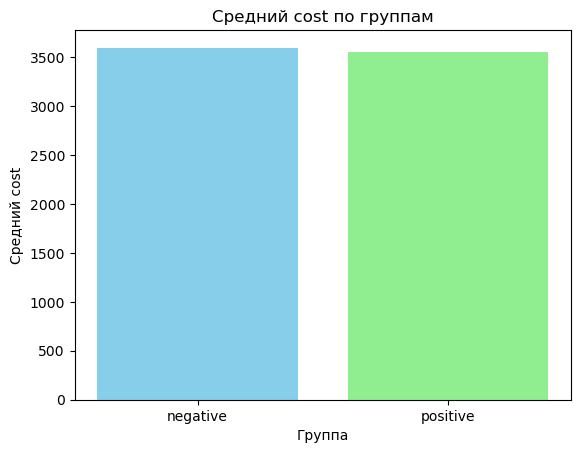

In [6]:
# Создаем график
plt.bar(mean_cost_by_company.index, mean_cost_by_company.values, color=['skyblue','lightgreen'])
plt.xlabel('Группа')
plt.ylabel('Средний cost')
plt.title('Средний cost по группам')
plt.show()

### Так как средний чек между двумя группами различается незначительно, то выручка в группах будет зависеть от количества пользователей в каждой группе

### Посчитаем средний возраст клиентов

In [208]:
# Группируем данные по 'first_company' и вычисляем средний возраст
mean_age_by_company = test_date_df.groupby('first_company')['age'].mean()

In [209]:
# Выводим средний возраст
print("Средний возраст для 'positive' и 'negative' в колонке 'first_company':")
print(round(mean_age_by_company,1))

Средний возраст для 'positive' и 'negative' в колонке 'first_company':
first_company
negative    38.4
positive    38.7
Name: age, dtype: float64


In [210]:
# Выполняем t-test для проверки различия между группами 'positive' и 'negative'
positive_age = test_date_df[test_date_df['first_company'] == 'positive']['age']
negative_age = test_date_df[test_date_df['first_company'] == 'negative']['age']

t_statistic, p_value = stats.ttest_ind(positive_age, negative_age)

# Выводим результаты t-test
print("\nРезультаты t-test:")
print(f"t-статистика: {t_statistic}")
print(f"p-значение: {p_value}")

# Проверяем статистическую значимость различия
alpha = 0.05
if p_value < alpha:
    print("\nРазличие статистически значимо (p < 0.05)")
else:
    print("\nРазличие не является статистически значимым (p >= 0.05)")


Результаты t-test:
t-статистика: 2.6267571559912204
p-значение: 0.008623197040549563

Различие статистически значимо (p < 0.05)


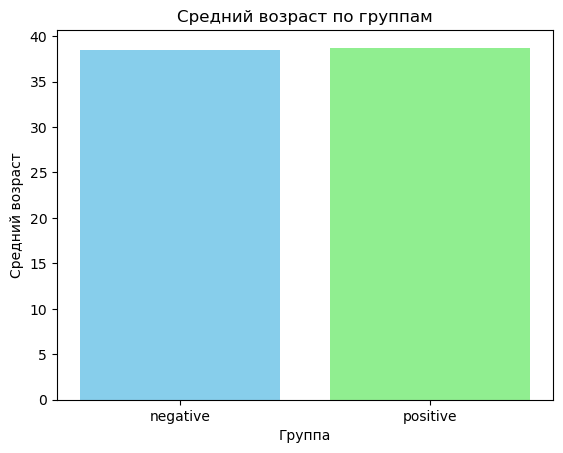

In [211]:
# Создаем график
plt.bar(mean_age_by_company.index, mean_age_by_company.values, color=['skyblue','lightgreen'])
plt.xlabel('Группа')
plt.ylabel('Средний возраст')
plt.title('Средний возраст по группам')
plt.show()

### Хоть статистически различия и значимы. Но в реальности возраст клиентов практически одинаков - 38 лет.

### Посмотрим на распределение цветов в разных группах участников

In [212]:
# Фильтруем данные по первой группе 'positive'
positive_df = test_date_df[test_date_df['first_company'] == 'positive']

In [213]:
# Группируем и подсчитываем цвета для первой группы 'positive'
color_counts_positive = positive_df['main_color'].value_counts()

In [214]:
# Сортируем в порядке убывания и выбираем топ-10 цветов
top_colors_positive = color_counts_positive.sort_values(ascending=False).head(10)

In [215]:
colors_style = {
    'белый': 'lightgray',
    'зеленый': 'lightgreen',
    'бежевый': 'lightcoral',
    'мультицвет': 'pink',  
    'черный': 'black',
    'синий': 'lightblue',
    'красный': 'red',
    'темно-синий': 'darkblue',
    'серый': 'darkgray',  
    'другой': 'purple' 
}

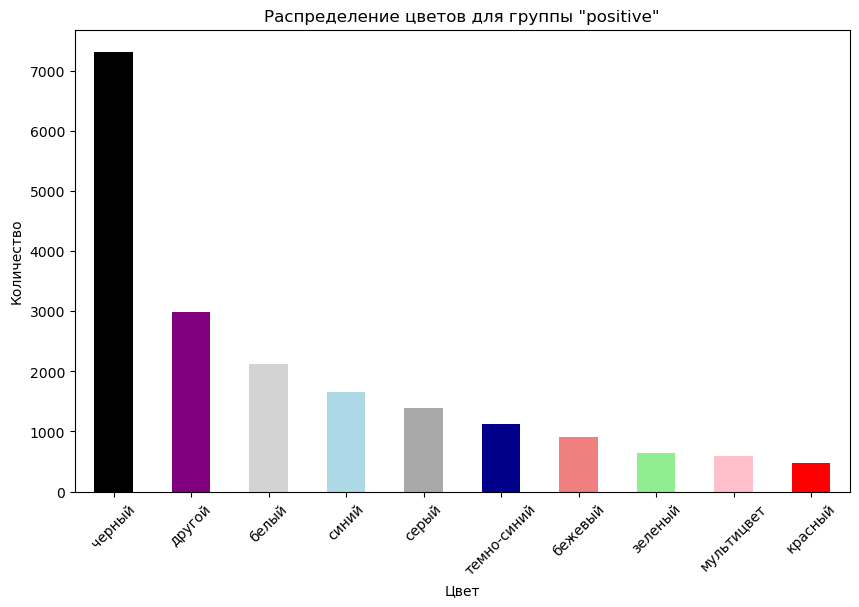

In [216]:
# Создаем график распределения цветов для группы 'positive'
plt.figure(figsize=(10, 6))
top_colors_positive.plot(kind='bar', color=[colors_style[color] for color in top_colors_positive.index])
plt.xlabel('Цвет')
plt.ylabel('Количество')
plt.title('Распределение цветов для группы "positive"')
plt.xticks(rotation=45)
plt.show()

In [218]:
# Фильтруем данные по второй группе 'negative'
negative_df = test_date_df[test_date_df['first_company'] == 'negative']

In [219]:
# Группируем и подсчитываем цвета для второй группы 'negative'
color_counts_negative = negative_df['main_color'].value_counts()

In [220]:
# Сортируем в порядке убывания и выбираем топ-10 цветов
top_colors_negative = color_counts_negative.sort_values(ascending=False).head(10)

In [221]:
top_colors_negative

черный         5879
другой         2364
белый          1832
синий          1260
серый          1077
темно-синий     841
бежевый         763
мультицвет      508
зеленый         490
красный         383
Name: main_color, dtype: int64

In [224]:
colors_style = {
    'белый': 'lightgray',
    'зеленый': 'pink',
    'бежевый': 'lightcoral',
    'мультицвет': 'lightgreen',  
    'черный': 'black',
    'синий': 'lightblue',
    'красный': 'red',
    'темно-синий': 'darkblue',
    'серый': 'darkgray', 
    'другой': 'purple'  
}

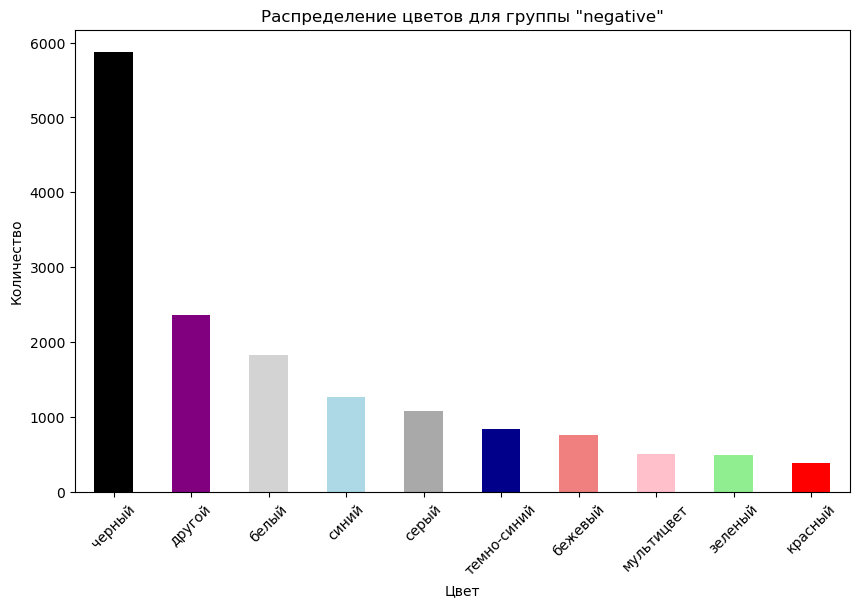

In [225]:
# Создаем график распределения цветов для группы 'negative'
plt.figure(figsize=(10, 6))
top_colors_negative.plot(kind='bar', color=[colors_style[color] for color in top_colors_positive.index])
plt.xlabel('Цвет')
plt.ylabel('Количество')
plt.title('Распределение цветов для группы "negative"')
plt.xticks(rotation=45)
plt.show()

### Посмотрим на распределение катогорий товаров в разных группах участников

In [147]:
# Фильтруем данные по первой группе 'positive'
#positive_df = test_date_df[test_date_df['first_company'] == 'positive']

In [226]:
# Группируем и подсчитываем категории товаров для первой группы 'positive'
сategory_counts_positive = positive_df['product_category'].value_counts()

In [227]:
# Сортируем в порядке убывания и выбираем топ-10 категорий
top_сategory_positive = сategory_counts_positive.sort_values(ascending=False).head(10)

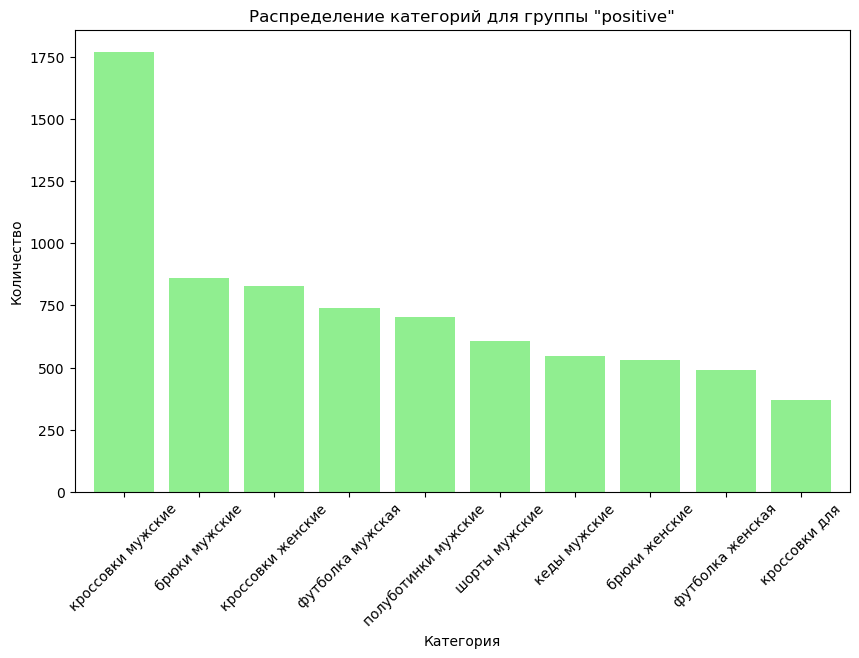

In [228]:
# Создаем график распределения категорий для группы 'positive'
plt.figure(figsize=(10, 6))
top_сategory_positive.plot(kind='bar', color='lightgreen', width=0.8)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.title('Распределение категорий для группы "positive"')
plt.xticks(rotation=45)
plt.show()

In [182]:
# Фильтруем данные по первой группе 'positive'
#negative_df = test_date_df[test_date_df['first_company'] == 'negative']

In [183]:
# Группируем и подсчитываем категории товаров для первой группы 'negative'
сategory_counts_negative = negative_df['product_category'].value_counts()

In [184]:
# Сортируем в порядке убывания и выбираем топ-10 категорий
top_сategory_negative = сategory_counts_negative.sort_values(ascending=False).head(10)

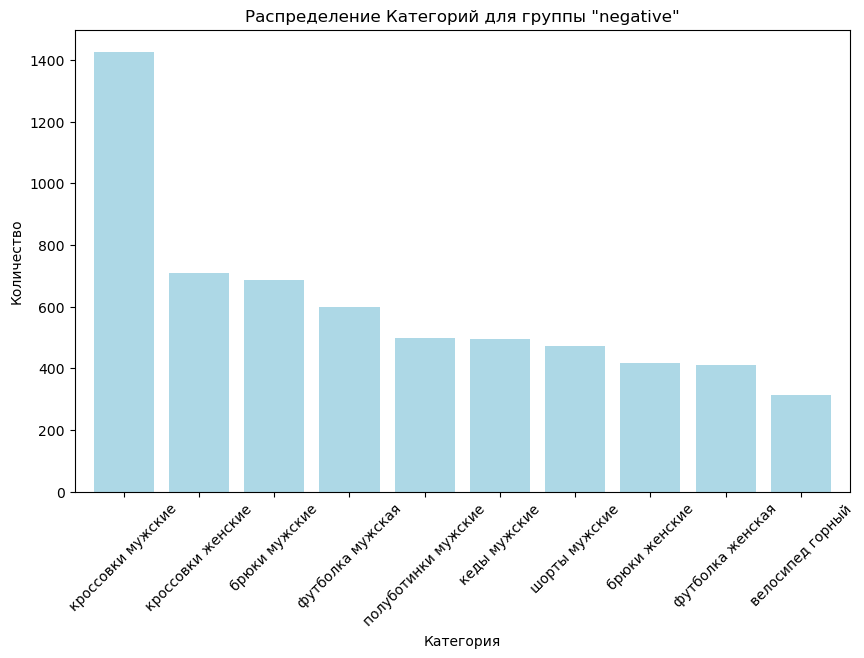

In [185]:
# Создаем график распределения категорий для группы 'negative'
plt.figure(figsize=(10, 6))
top_сategory_negative.plot(kind='bar', color='skyblue',width=0.8)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.title('Распределение Категорий для группы "negative"')
plt.xticks(rotation=45)
plt.show()

### Посмотрим на распределение брендов в разных группах участников

In [186]:
# Группируем и подсчитываем категории товаров для первой группы 'positive'
brand_counts_positive = positive_df['brand'].value_counts()

In [187]:
# Сортируем в порядке убывания и выбираем топ-10 категорий
top_brand_positive = brand_counts_positive.sort_values(ascending=False).head(10)

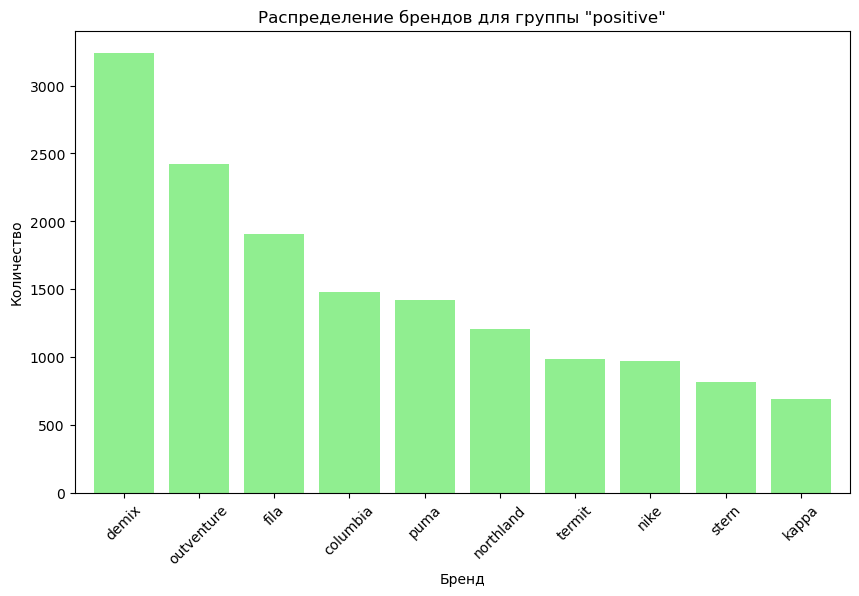

In [188]:
# Создаем график распределения брендов для группы 'positive'
plt.figure(figsize=(10, 6))
top_brand_positive.plot(kind='bar', color='lightgreen', width=0.8)
plt.xlabel('Бренд')
plt.ylabel('Количество')
plt.title('Распределение брендов для группы "positive"')
plt.xticks(rotation=45)
plt.show()

In [189]:
# Группируем и подсчитываем категории товаров для первой группы 'negative'
brand_counts_negative = negative_df['brand'].value_counts()

In [190]:
# Сортируем в порядке убывания и выбираем топ-10 категорий
top_brand_negative = brand_counts_negative.sort_values(ascending=False).head(10)

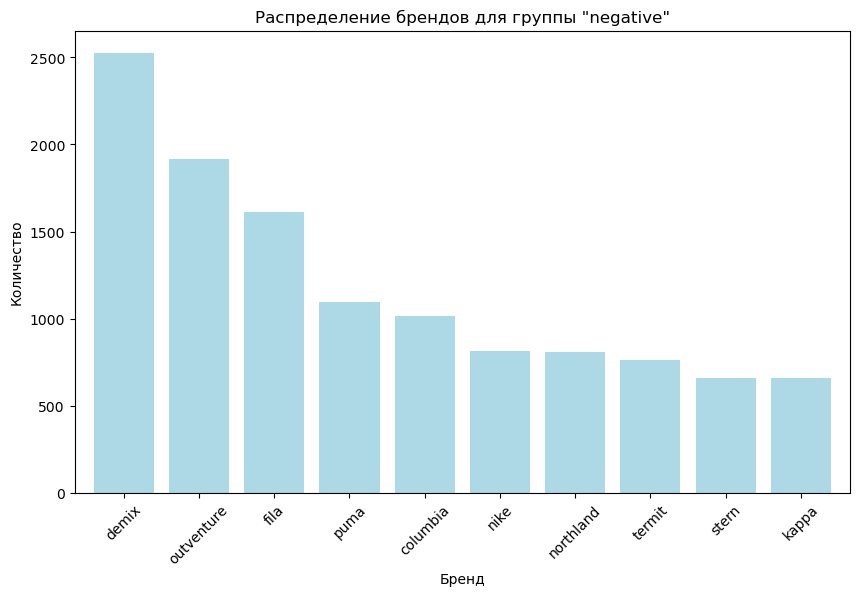

In [191]:
# Создаем график распределения брендов для группы 'negative'
plt.figure(figsize=(10, 6))
top_brand_negative.plot(kind='bar', color='skyblue', width=0.8)
plt.xlabel('Бренд')
plt.ylabel('Количество')
plt.title('Распределение брендов для группы "negative"')
plt.xticks(rotation=45)
plt.show()

### 4.2 Посчитаем метрики второй рекламной компании

In [229]:
company_2_df = df_company[df_company['second_company'] == 'positive']
print(company_2_df.shape)
company_2_df.head()

(193996, 16)


,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand,first_company,second_company
3,3,1599.0,1,0,13,1,31,среднее,1134,32,0.4304,белый,бутсы мужские,gsd,negative,positive
4,3,7199.0,1,0,27,1,31,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma,negative,positive
5,3,2799.0,1,1,34,1,31,среднее,1134,32,0.4304,белый,кеды мужские,fila,negative,positive
6,3,2999.0,1,0,34,1,31,среднее,1134,32,0.4304,серый,полуботинки мужские,outventure,negative,positive
7,4,9199.0,0,0,0,0,35,среднее,1134,32,0.5072,черный,роликовые коньки,roces,positive,positive


In [230]:
average_cost_by_day = company_2_df.groupby('dt')['cost'].mean().reset_index()

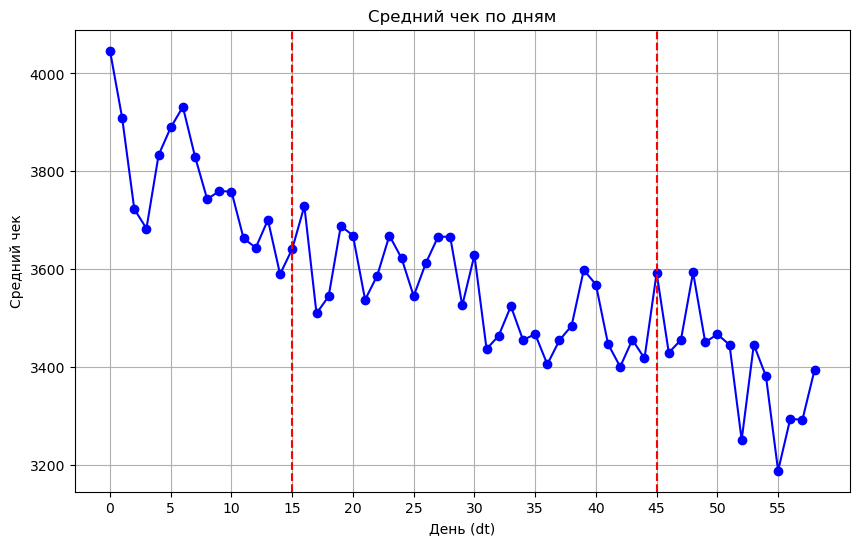

In [231]:
# Построим график среднего показателя cost по дням
plt.figure(figsize=(10, 6))
plt.plot(average_cost_by_day['dt'], average_cost_by_day['cost'], marker='o', linestyle='-', color='b')
plt.title('Средний чек по дням')
plt.xlabel('День (dt)')
plt.ylabel('Средний чек')
plt.grid(True)

# Добавим вертикальные линии для 15 и 45 дня
plt.axvline(x=15, color='r', linestyle='--', label='15 день')
plt.axvline(x=45, color='r', linestyle='--', label='45 день')

# Установим разбиение по оси X каждые 5 дней
plt.xticks(range(0, max(average_cost_by_day['dt']) + 1, 5))

plt.show()

In [232]:
# Вычислим выручку для каждого дня
total_cost_by_day = company_2_df.groupby('dt')['cost'].sum().reset_index()

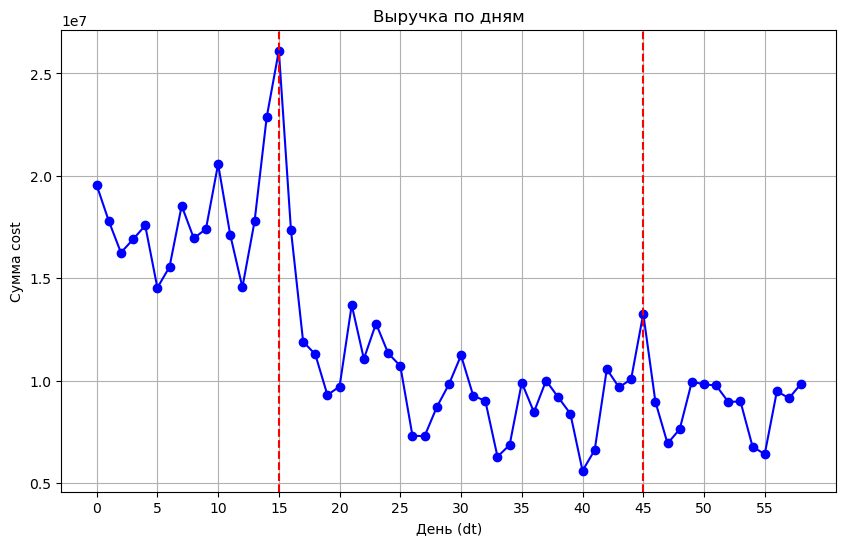

In [233]:
# Создадим линейный график выручки по дням
plt.figure(figsize=(10, 6))
plt.plot(total_cost_by_day['dt'], total_cost_by_day['cost'], marker='o', linestyle='-', color='b')
plt.title('Выручка по дням')
plt.xlabel('День (dt)')
plt.ylabel('Сумма cost')
plt.grid(True)

# Добавим вертикальные линии для 15 и 45 дня
plt.axvline(x=15, color='r', linestyle='--', label='15 день')
plt.axvline(x=45, color='r', linestyle='--', label='45 день')




# Установим разбиение по оси X каждые 5 дней
plt.xticks(range(0, max(total_cost_by_day['dt']) + 1, 5))

plt.show()

In [14]:
# Вычислите количество покупателей для каждого дня
customers_by_day = company_2_df.groupby('dt')['id'].nunique().reset_index()

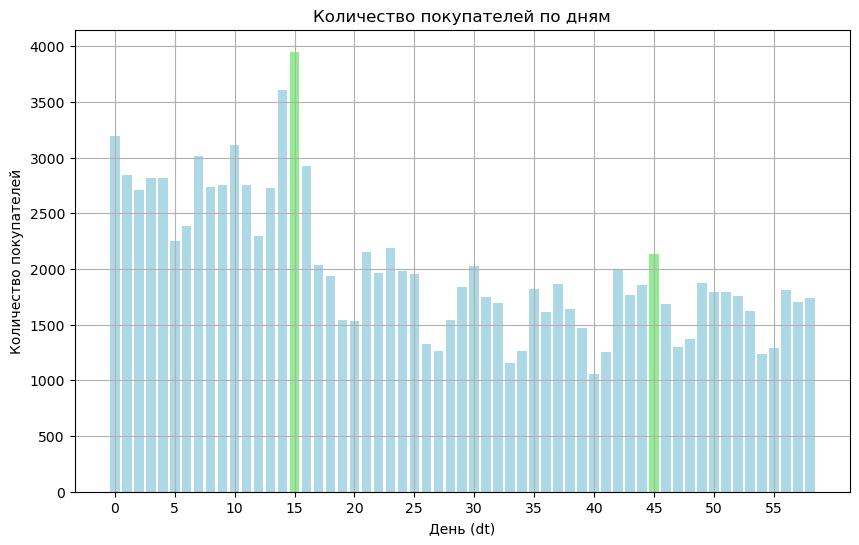

In [33]:
# Создадим столбчатый график количества покупателей по дням
plt.figure(figsize=(10, 6))
plt.bar(customers_by_day['dt'], customers_by_day['id'], color='skyblue')
plt.title('Количество покупателей по дням')
plt.xlabel('День (dt)')
plt.ylabel('Количество покупателей')
plt.grid(True)


# Установим разбиение по оси X каждые 5 дней
plt.xticks(range(0, max(customers_by_day['dt']) + 1, 5))


# Выделим столбец на 15 и 45 день цветом
plt.bar(15, customers_by_day[customers_by_day['dt'] == 15]['id'], color='lightgreen')
plt.bar(45, customers_by_day[customers_by_day['dt'] == 45]['id'], color='lightgreen')


plt.show()

In [47]:
# Создадим список с данными для 15 и 45 дней и для остальных дней
data_15_45_days = company_2_df[company_2_df['dt'].isin([15, 45])]
data_other_days = company_2_df[~company_2_df['dt'].isin([15, 45])]


### 5. Разбиение на кластеры

In [3]:
print(df_company.shape)
df_company.head(15)

(786260, 16)


,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand,first_company,second_company
0,0,5599.0,0,1,7,0,36,среднее,1201,32,0.5072,белый,велосипед горный,stern,positive,negative
1,0,1499.0,0,0,37,0,36,среднее,1201,32,0.5072,зеленый,стол,outventure,positive,negative
2,0,4799.0,0,0,37,0,36,среднее,1201,32,0.5072,бежевый,набор,outventure,positive,negative
3,3,1599.0,1,0,13,1,31,среднее,1134,32,0.4304,белый,бутсы мужские,gsd,negative,positive
4,3,7199.0,1,0,27,1,31,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma,negative,positive
5,3,2799.0,1,1,34,1,31,среднее,1134,32,0.4304,белый,кеды мужские,fila,negative,positive
6,3,2999.0,1,0,34,1,31,среднее,1134,32,0.4304,серый,полуботинки мужские,outventure,negative,positive
7,4,9199.0,0,0,0,0,35,среднее,1134,32,0.5072,черный,роликовые коньки,roces,positive,positive
8,4,4999.0,0,0,0,0,35,среднее,1134,32,0.5072,белый,шлем,fila,positive,positive
9,4,6999.0,0,0,1,0,35,среднее,1134,32,0.5072,мультицвет,роликовые коньки,roces,positive,positive


In [111]:
# Выбор колонок для кластеризации
data_for_clustering = df_company[['cost', 'product_category', 
                                  'brand', 'age', 'education', 'city', 'country', 'personal_coef', 'main_color']]
print(data_for_clustering.shape)
data_for_clustering.head()

(786260, 9)


,cost,product_category,brand,age,education,city,country,personal_coef,main_color
0,5599.0,велосипед горный,stern,36,среднее,1201,32,0.5072,белый
1,1499.0,стол,outventure,36,среднее,1201,32,0.5072,зеленый
2,4799.0,набор,outventure,36,среднее,1201,32,0.5072,бежевый
3,1599.0,бутсы мужские,gsd,31,среднее,1134,32,0.4304,белый
4,7199.0,мяч футбольный,puma,31,среднее,1134,32,0.4304,мультицвет


---

In [112]:
# Кодирование категориальных колонок
label_encoder = LabelEncoder()
data_for_clustering_le = data_for_clustering.copy()
data_for_clustering_le['product_category_encoded'] = label_encoder.fit_transform(data_for_clustering['product_category'])
data_for_clustering_le['brand_encoded'] = label_encoder.fit_transform(data_for_clustering['brand'])
data_for_clustering_le['education_encoded'] = label_encoder.fit_transform(data_for_clustering['education'])
data_for_clustering_le['main_color_encoded'] = label_encoder.fit_transform(data_for_clustering['main_color'])
data_for_clustering_le = data_for_clustering_le.drop(columns=['product_category', 'brand', 'education', 'main_color'])
data_for_clustering_le.head()

,cost,age,city,country,personal_coef,product_category_encoded,brand_encoded,education_encoded,main_color_encoded
0,5599.0,36,1201,32,0.5072,154,347,1,56
1,1499.0,36,1201,32,0.5072,1145,267,1,104
2,4799.0,36,1201,32,0.5072,704,267,1,52
3,1599.0,31,1134,32,0.4304,136,156,1,56
4,7199.0,31,1134,32,0.4304,701,283,1,161


In [113]:
# Масштабирование данных
scaler = StandardScaler()
scaler_data = scaler.fit_transform(data_for_clustering_le)

In [114]:
# Пустой список для записи значений инерции
inertia_values = []

# Перебор разного числа кластеров и вычисление инерции
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaler_data)
    inertia_values.append(kmeans.inertia_)


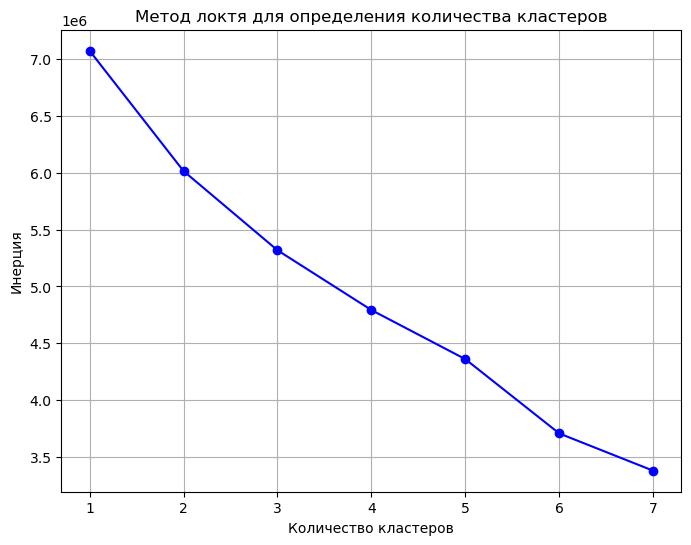

In [115]:
# Построение графика инерции
plt.figure(figsize=(8, 6))
plt.plot(range(1, 8), inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения количества кластеров')
plt.grid()
plt.show()

---

In [116]:
data_for_clustering.head()

,cost,product_category,brand,age,education,city,country,personal_coef,main_color
0,5599.0,велосипед горный,stern,36,среднее,1201,32,0.5072,белый
1,1499.0,стол,outventure,36,среднее,1201,32,0.5072,зеленый
2,4799.0,набор,outventure,36,среднее,1201,32,0.5072,бежевый
3,1599.0,бутсы мужские,gsd,31,среднее,1134,32,0.4304,белый
4,7199.0,мяч футбольный,puma,31,среднее,1134,32,0.4304,мультицвет


In [117]:
# Колонки для масштабирования и кодирования
numeric_features = ['cost', 'city', 'age', 'country', 'country']
categorical_features = ['product_category', 'brand', 'education', 'main_color']

In [118]:
# Создание преобразователя колонок
transformers = [
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), categorical_features)
]

In [119]:
# Создание конвейера для предварительной обработки данных
preprocessor = ColumnTransformer(transformers)

In [120]:
# Создание конвейера для кластеризации
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])


In [121]:
# Выполнение кластеризации
df_company['cluster'] = pipeline.fit_predict(data_for_clustering)

---

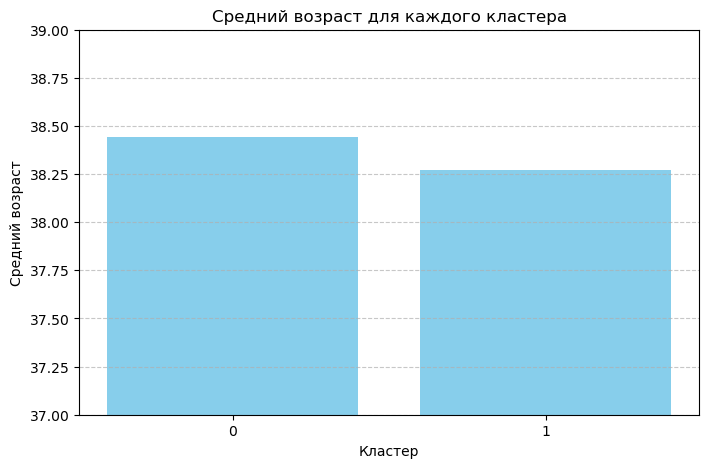

In [122]:
# Группировка данных по кластерам и вычисление среднего возраста
clustered_data = df_company.groupby('cluster')['age'].mean()

# Создание графика
plt.figure(figsize=(8, 5))
plt.bar(clustered_data.index, clustered_data.values, color='skyblue')
plt.xlabel('Кластер')
plt.ylabel('Средний возраст')
plt.title('Средний возраст для каждого кластера')
plt.xticks(clustered_data.index)
plt.ylim(37, 39)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

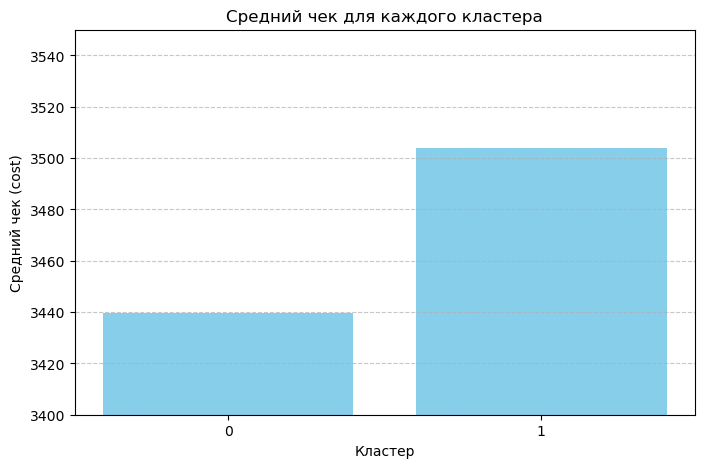

In [125]:
# Группировка данных по кластерам и вычисление среднего чека
clustered_data = df_company.groupby('cluster')['cost'].mean()

# Создание графика
plt.figure(figsize=(8, 5))
plt.bar(clustered_data.index, clustered_data.values, color='skyblue')
plt.xlabel('Кластер')
plt.ylabel('Средний чек (cost)')
plt.title('Средний чек для каждого кластера')
plt.xticks(clustered_data.index)
plt.ylim(3400, 3550)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

---

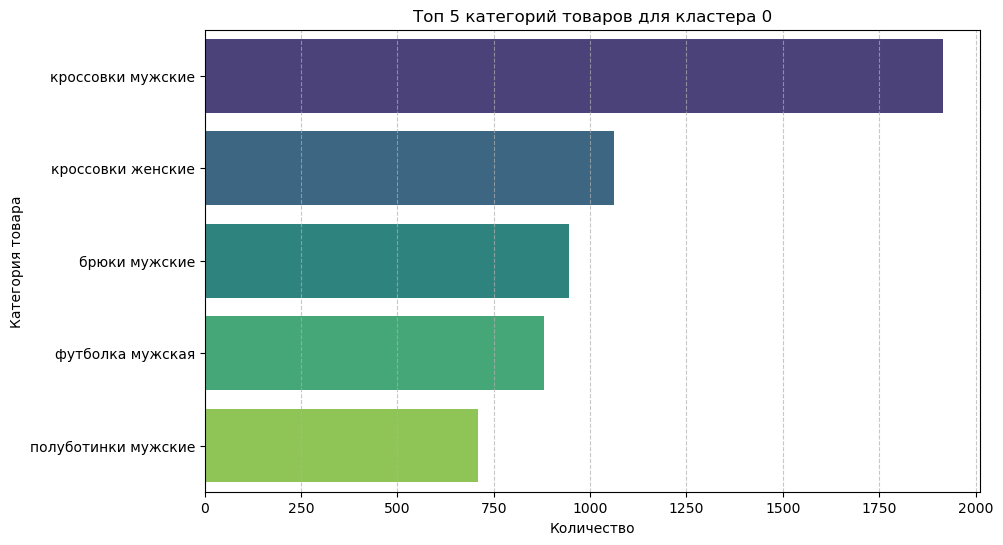

In [126]:
# Выбор данных только для кластера 0
cluster_0_data = df_company[df_company['cluster'] == 0]

# Получение топ 5 категорий товаров для кластера 0
top_categories_cluster_0 = cluster_0_data['product_category'].value_counts().nlargest(5)

# Создание горизонтальной гистограммы
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories_cluster_0.values, y=top_categories_cluster_0.index, palette="viridis")
plt.xlabel('Количество')
plt.ylabel('Категория товара')
plt.title('Топ 5 категорий товаров для кластера 0')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

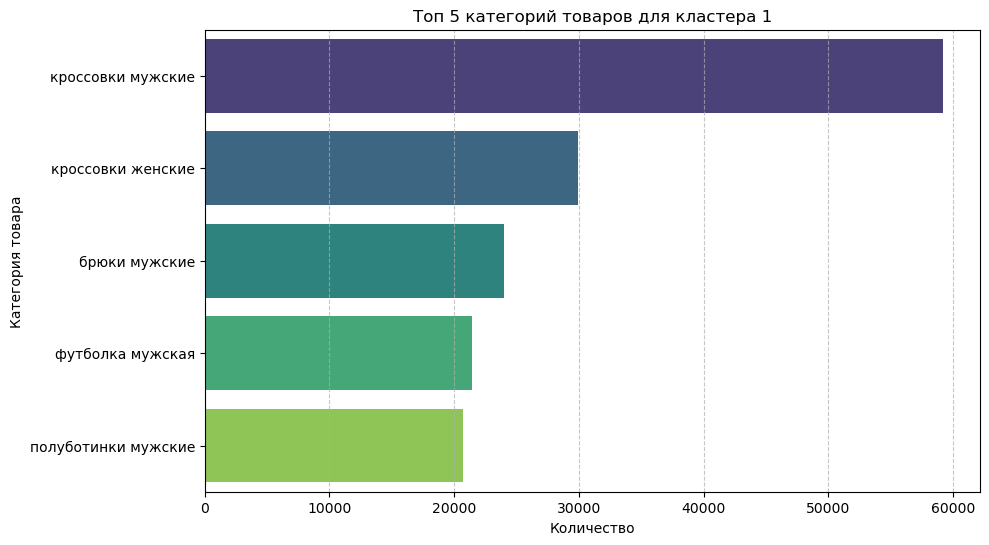

In [127]:
# Выбор данных только для кластера 1
cluster_1_data = df_company[df_company['cluster'] == 1]

# Получение топ 5 категорий товаров для кластера 1
top_categories_cluster_1 = cluster_1_data['product_category'].value_counts().nlargest(5)

# Создание горизонтальной гистограммы
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories_cluster_1.values, y=top_categories_cluster_1.index, palette="viridis")
plt.xlabel('Количество')
plt.ylabel('Категория товара')
plt.title('Топ 5 категорий товаров для кластера 1')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

---

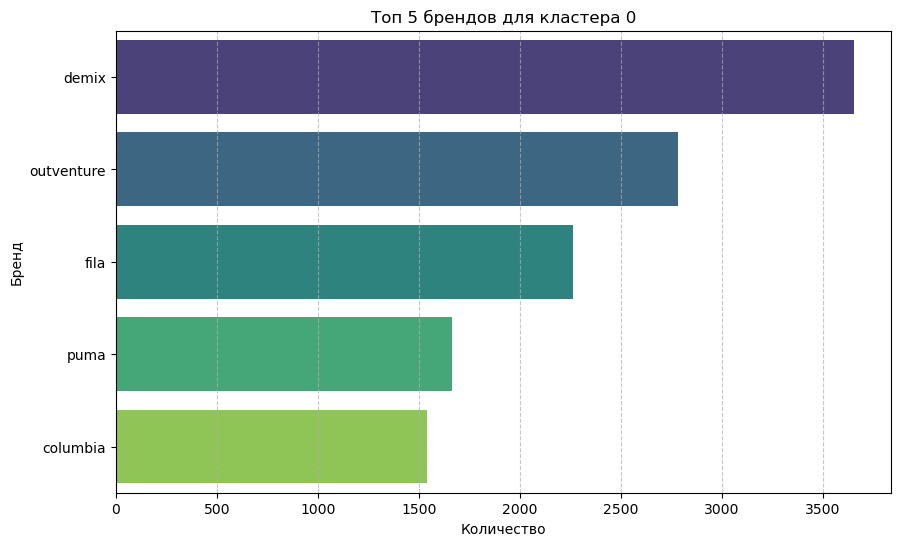

In [128]:
# Получение топ 5 брендов для кластера 0
top_brands_cluster_0 = cluster_0_data['brand'].value_counts().nlargest(5)

# Создание гистограммы
plt.figure(figsize=(10, 6))
sns.barplot(x=top_brands_cluster_0.values, y=top_brands_cluster_0.index, palette="viridis")
plt.xlabel('Количество')
plt.ylabel('Бренд')
plt.title('Топ 5 брендов для кластера 0')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

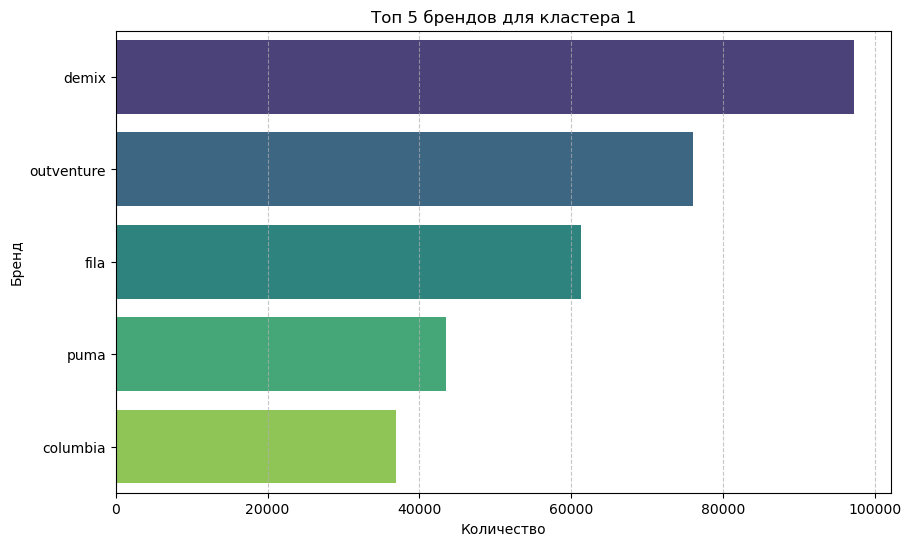

In [129]:
# Получение топ 5 брендов для кластера 1
top_brands_cluster_1 = cluster_1_data['brand'].value_counts().nlargest(5)

# Создание гистограммы
plt.figure(figsize=(10, 6))
sns.barplot(x=top_brands_cluster_1.values, y=top_brands_cluster_1.index, palette="viridis")
plt.xlabel('Количество')
plt.ylabel('Бренд')
plt.title('Топ 5 брендов для кластера 1')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

---

In [130]:
# Выбор данных только для кластера 0
cluster_0_data = df_company[df_company['cluster'] == 0]


In [131]:
cluster_0_data

,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand,first_company,second_company,cluster
95,20,479.0,0,0,5,0,33,среднее,574,32,0.5072,мультицвет,ремонтный комплект,bestway,NaN,negative,0
96,20,5849.0,0,1,5,0,33,среднее,574,32,0.5072,зеленый,другое,bestway,NaN,negative,0
97,20,399.0,0,0,5,0,33,среднее,574,32,0.5072,черный,сменный клапан,bestway,NaN,negative,0
98,20,5849.0,0,1,6,0,33,среднее,574,32,0.5072,зеленый,другое,bestway,NaN,negative,0
99,20,399.0,0,0,6,0,33,среднее,574,32,0.5072,черный,сменный клапан,bestway,NaN,negative,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786067,177963,1889.0,0,1,16,0,33,среднее,250,32,0.5072,черный,брюки женские,demix,negative,negative,0
786068,177963,4499.0,0,0,21,0,33,среднее,250,32,0.5072,мультицвет,сумка для,outventure,negative,negative,0
786069,177963,1999.0,0,0,22,0,33,среднее,250,32,0.5072,сапфировый,тент,outventure,negative,negative,0
786070,177963,6799.0,1,1,23,0,33,среднее,250,32,0.5072,черный,кроссовки мужские,puma,negative,negative,0


In [132]:
# Выделение данных со скидкой и без скидки
with_discount = cluster_0_data[cluster_0_data['base_sale'] == 1]['cost']
without_discount = cluster_0_data[cluster_0_data['base_sale'] == 0]['cost']

# Вычисление среднего чека
mean_with_discount = with_discount.mean()
mean_without_discount = without_discount.mean()

In [136]:
# Вывод среднего чека
print(f"Средний чек со скидкой для кластера 0: {mean_with_discount:.2f}")
print(f"Средний чек без скидки для кластера 0: {mean_without_discount:.2f}")

# Проведение t-теста
t_statistic, p_value = stats.ttest_ind(with_discount, without_discount, equal_var=False)

# Вывод результатов t-теста
print("\nРезультаты t-теста:")
print(f"T-Statistic: {t_statistic:.2f}")
print(f"P-Value: {p_value:.4f}")

# Оценка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("\nРазличие статистически значимо (отвергаем нулевую гипотезу)")
else:
    print("\nРазличие статистически не значимо (не отвергаем нулевую гипотезу)")

Средний чек со скидкой для кластера 0: 3088.92
Средний чек без скидки для кластера 0: 3659.73

Результаты t-теста:
T-Statistic: -19.48
P-Value: 0.0000

Различие статистически значимо (отвергаем нулевую гипотезу)


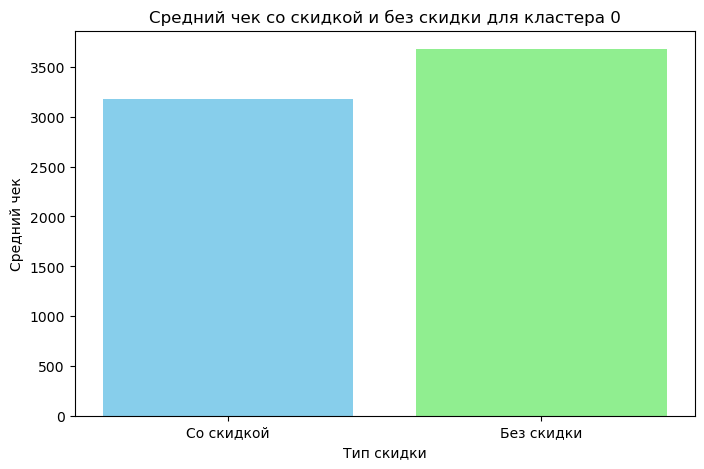

In [144]:
# Создание графика
plt.figure(figsize=(8, 5))
plt.bar(['Со скидкой', 'Без скидки'], [mean_with_discount, mean_without_discount], color=['skyblue', 'lightgreen'])
plt.xlabel('Тип скидки')
plt.ylabel('Средний чек')
plt.title('Средний чек со скидкой и без скидки для кластера 0')
#plt.ylim(3000, 3700)

plt.show()

In [138]:
# Выбор данных только для кластера 1
cluster_1_data = df_company[df_company['cluster'] == 1]


In [139]:
# Выделение данных со скидкой и без скидки
with_discount = cluster_1_data[cluster_1_data['base_sale'] == 1]['cost']
without_discount = cluster_1_data[cluster_1_data['base_sale'] == 0]['cost']

# Вычисление среднего чека
mean_with_discount = with_discount.mean()
mean_without_discount = without_discount.mean()

In [140]:
# Вывод среднего чека
print(f"Средний чек со скидкой для кластера 1: {mean_with_discount:.2f}")
print(f"Средний чек без скидки для кластера 1: {mean_without_discount:.2f}")

# Проведение t-теста
t_statistic, p_value = stats.ttest_ind(with_discount, without_discount, equal_var=False)

# Вывод результатов t-теста
print("\nРезультаты t-теста:")
print(f"T-Statistic: {t_statistic:.2f}")
print(f"P-Value: {p_value:.4f}")

# Оценка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("\nРазличие статистически значимо (отвергаем нулевую гипотезу)")
else:
    print("\nРазличие статистически не значимо (не отвергаем нулевую гипотезу)")

Средний чек со скидкой для кластера 1: 3183.61
Средний чек без скидки для кластера 1: 3680.69

Результаты t-теста:
T-Statistic: -87.95
P-Value: 0.0000

Различие статистически значимо (отвергаем нулевую гипотезу)


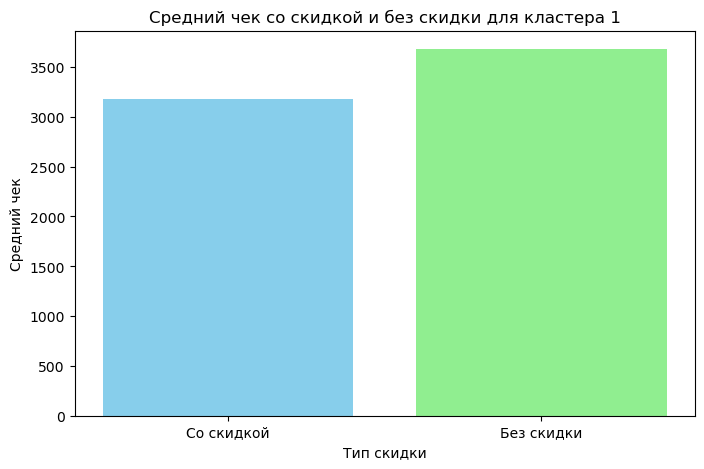

In [145]:
# Создание графика
plt.figure(figsize=(8, 5))
plt.bar(['Со скидкой', 'Без скидки'], [mean_with_discount, mean_without_discount], color=['skyblue', 'lightgreen'])
plt.xlabel('Тип скидки')
plt.ylabel('Средний чек')
plt.title('Средний чек со скидкой и без скидки для кластера 1')
#plt.ylim(3000, 3700)

# Вывод графика
plt.show()

---

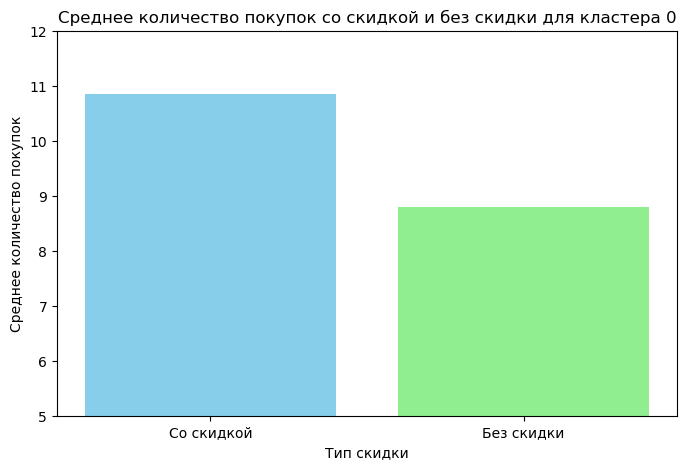

In [148]:
# Вычисление среднего количества покупок со скидкой и без скидки
total_purchases_with_discount = cluster_0_data[cluster_0_data['base_sale'] == 1]['id'].nunique()
total_purchases_without_discount = cluster_0_data[cluster_0_data['base_sale'] == 0]['id'].nunique()

# Вычисление среднего количества покупок
mean_purchases_with_discount =  len(cluster_0_data) / total_purchases_with_discount 
mean_purchases_without_discount =  len(cluster_0_data) /total_purchases_without_discount 

# Создание графика
plt.figure(figsize=(8, 5))
plt.bar(['Со скидкой', 'Без скидки'], [mean_purchases_with_discount, mean_purchases_without_discount], color=['skyblue', 'lightgreen'])
plt.xlabel('Тип скидки')
plt.ylabel('Среднее количество покупок')
plt.title('Среднее количество покупок со скидкой и без скидки для кластера 0')
plt.ylim(5, 12)

# Вывод графика
plt.show()

In [149]:
print(f"Среднее количество покупок со скидкой в кластере 0: {round(mean_purchases_with_discount,1)}")
print(f"Среднее количество покупок без скидки в кластере 0: {round(mean_purchases_without_discount,1)}")

Среднее количество покупок со скидкой в кластере 0: 10.9
Среднее количество покупок без скидки в кластере 0: 8.8


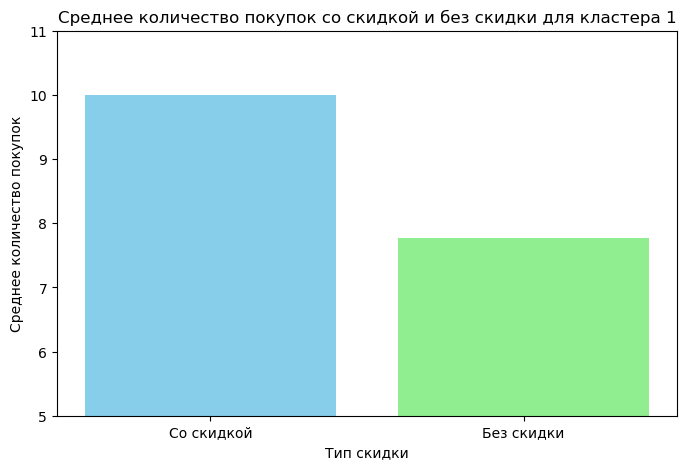

In [150]:
# Вычисление среднего количества покупок со скидкой и без скидки
total_purchases_with_discount = cluster_1_data[cluster_1_data['base_sale'] == 1]['id'].nunique()
total_purchases_without_discount = cluster_1_data[cluster_1_data['base_sale'] == 0]['id'].nunique()

# Вычисление среднего количества покупок
mean_purchases_with_discount =  len(cluster_1_data) / total_purchases_with_discount 
mean_purchases_without_discount =  len(cluster_1_data) /total_purchases_without_discount 

# Создание графика
plt.figure(figsize=(8, 5))
plt.bar(['Со скидкой', 'Без скидки'], [mean_purchases_with_discount, mean_purchases_without_discount], color=['skyblue', 'lightgreen'])
plt.xlabel('Тип скидки')
plt.ylabel('Среднее количество покупок')
plt.title('Среднее количество покупок со скидкой и без скидки для кластера 1')
plt.ylim(5, 11)

# Вывод графика
plt.show()

In [151]:
print(f"Среднее количество покупок со скидкой в кластере 1: {round(mean_purchases_with_discount,1)}")
print(f"Среднее количество покупок без скидки в кластере 1: {round(mean_purchases_without_discount,1)}")

Среднее количество покупок со скидкой в кластере 1: 10.0
Среднее количество покупок без скидки в кластере 1: 7.8


---

### 5. Построение модели

In [168]:
df_company = pd.read_csv('df_company.csv')
print(df_company.shape)
df_company.head()

(786260, 16)


,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand,first_company,second_company
0,0,5599.0,0,1,7,0,36,среднее,1201,32,0.5072,белый,велосипед горный,stern,positive,negative
1,0,1499.0,0,0,37,0,36,среднее,1201,32,0.5072,зеленый,стол,outventure,positive,negative
2,0,4799.0,0,0,37,0,36,среднее,1201,32,0.5072,бежевый,набор,outventure,positive,negative
3,3,1599.0,1,0,13,1,31,среднее,1134,32,0.4304,белый,бутсы мужские,gsd,negative,positive
4,3,7199.0,1,0,27,1,31,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma,negative,positive


In [169]:
# Загрузим данные и отфильтруем их для страны 32 и города 1188 
df_city_1188 = df_company[(df_company['country'] == 32) & (df_company['city'] == 1188)]
df_city_1188 = df_city_1188.drop(columns=['first_company', 'second_company','city', 'country'])
print(df_city_1188.shape)
df_city_1188.head()

(88889, 12)


,id,cost,product_sex,base_sale,dt,gender,age,education,personal_coef,main_color,product_category,brand
14,6,4999.0,1,0,1,1,52,среднее,0.4304,лимонный,кроссовки для,geox
15,6,4799.0,1,1,3,1,52,среднее,0.4304,черный,кеды мужские,reebok
16,6,999.0,1,0,8,1,52,среднее,0.4304,темно-синий,футболка мужская,kappa
17,6,1119.0,1,1,11,1,52,среднее,0.4304,синий,бейсболка детская,nike
18,6,299.0,1,0,11,1,52,среднее,0.4304,синий,носки детские,demix


In [170]:
df_city_1188.product_category.value_counts()

кроссовки мужские      6783
кроссовки женские      3816
брюки мужские          2563
полуботинки мужские    2501
футболка мужская       2217
                       ... 
щитки хоккейные           1
внешний аккумулятор       1
батут складной            1
таганок                   1
рубашка мусжкая           1
Name: product_category, Length: 1336, dtype: int64

In [171]:
# Создаем колонку "target" с помощью условия
df_city_1188['target'] = df_city_1188['product_category'].apply(lambda x: 1 if x == 'кроссовки мужские' else 0)
df_city_1188 = df_city_1188.drop(columns=['product_category','cost', 'id'])
print(df_city_1188.shape)
df_city_1188.head()

(88889, 10)


,product_sex,base_sale,dt,gender,age,education,personal_coef,main_color,brand,target
14,1,0,1,1,52,среднее,0.4304,лимонный,geox,0
15,1,1,3,1,52,среднее,0.4304,черный,reebok,0
16,1,0,8,1,52,среднее,0.4304,темно-синий,kappa,0
17,1,1,11,1,52,среднее,0.4304,синий,nike,0
18,1,0,11,1,52,среднее,0.4304,синий,demix,0


In [172]:
df_city_1188.target.value_counts()

0    82106
1     6783
Name: target, dtype: int64

In [173]:
# Разделим данные на два подмножества
df_positive = df_city_1188[df_city_1188['target'] == 1]
df_negative = df_city_1188[df_city_1188['target'] == 0]

In [176]:
# Выберем случайные примеры из отрицательного класса так, чтобы их количество стало равным количеству примеров в положительном классе
df_negative_undersampled = resample(df_negative, replace=False, n_samples=len(df_positive), random_state=42)

In [178]:
# Объединим андерсэмплированный отрицательный класс с положительным классом
df_undersampled_1188 = pd.concat([df_positive, df_negative_undersampled])
print(df_undersampled_1188.shape)
df_undersampled_1188.head()

(13566, 10)


,product_sex,base_sale,dt,gender,age,education,personal_coef,main_color,brand,target
19,1,0,11,1,52,среднее,0.4304,черный,adidas,1
20,1,0,13,1,52,среднее,0.4304,черный,adidas,1
22,1,0,18,1,52,среднее,0.4304,черный,nike,1
89,1,1,27,1,53,среднее,0.4304,синий,true,1
92,1,1,37,1,53,среднее,0.4304,синий,true,1


In [180]:
# Подготовка данных
X = df_undersampled_1188.drop(columns=['target'])
y = df_undersampled_1188['target']
# Преобразование категориальных признаков
X = pd.get_dummies(X)  

In [181]:
# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [182]:
# Масштабирование признаков 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 5.2 Обучение логистической регрессии

In [183]:
# Создадим модель логистической регрессии
model = LogisticRegression()

In [184]:
# Обучение модели на тренировочных данных
model.fit(X_train, y_train)

C:\Users\Denis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [185]:
# Предсказания на тестовом наборе данных
y_pred = model.predict(X_test)

In [186]:
# Оценка производительности модели на тестовых данных
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {accuracy:.2f}")

Accuracy on Test Data: 0.90


In [187]:
# Выполним кросс-валидацию для оценки точности модели
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Выведим оценки точности для каждого фолда
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Accuracy:", cross_val_scores.mean())

C:\Users\Denis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Denis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Cross-Validation Scores: [0.88246131 0.88647254 0.87652046 0.88536675 0.89347586]
Mean Accuracy: 0.8848593836113736


C:\Users\Denis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


---

In [188]:
# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


In [189]:
# Оценка F1-меры
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.2f}")

F1-Score: 0.91


In [190]:
# Оценка ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.2f}")

ROC-AUC: 0.90


In [191]:
# Матрица ошибок
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[1106  251]
 [  21 1336]]


Accuracy (Точность): 0.90. Это означает, что около 90% всех предсказаний, сделанных этой моделью, верны. Очень высокий показатель точности.

F1-Score (F1-мера): 0.91. Это высокий показатель F1-меры, который объединяет точность и полноту. Он близок к 1, что указывает на хорошее сбалансированное соотношение между точностью и полнотой.

ROC-AUC: 0.90. ROC-AUC близок к 1, что означает, что модель имеет высокую способность разделять классы и имеет хорошую площадь под кривой ROC.

### 5.3 Обучение случайного леса

In [192]:
# Создадим модель случайного леса
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

In [193]:
# Обучение модели на тренировочных данных
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [194]:
# Предсказания на тестовом наборе данных
y_pred_rf = model_rf.predict(X_test)

In [195]:
# Оценка производительности модели на тестовых данных
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy on Test Data: {accuracy:.2f}")

Accuracy on Test Data: 0.82


In [196]:
# Выполнии кросс-валидацию для оценки точности модели
cross_val_scores = cross_val_score(model_rf, X, y, cv=5, scoring='accuracy')

# Выведим оценки точности для каждого фолда
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Accuracy:", cross_val_scores.mean())

Cross-Validation Scores: [0.79955785 0.82307409 0.83155179 0.82454847 0.8308146 ]
Mean Accuracy: 0.8219093580650059


---

In [197]:
# Оценка точности
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


In [198]:
# Оценка F1-меры
f1 = f1_score(y_test, y_pred_rf)
print(f"F1-Score: {f1:.2f}")

F1-Score: 0.84


In [199]:
# Оценка ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_rf)
print(f"ROC-AUC: {roc_auc:.2f}")

ROC-AUC: 0.82


In [200]:
# Матрица ошибок
confusion = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[ 942  415]
 [  79 1278]]


Accuracy (Точность): 0.82. Это означает, что около 82% всех предсказаний, сделанных этой моделью, верны.

F1-Score (F1-мера): 0.84. Это хороший показатель F1-меры, который также близок к 1.

ROC-AUC: 0.82. ROC-AUC также является хорошим, но немного ниже, чем у модели логистической регрессии.

Модель логистической регрессии имеет более высокие метрики точности и F1-меры, что может быть связано с тем, что данные могут быть хорошо разделимы линейной гиперплоскостью. Она также имеет более высокий ROC-AUC, что свидетельствует о хорошей способности модели разделять классы.

---

In [234]:
df_company['target'] = 0

In [18]:
df_company.head()

,id,cost,product_sex,base_sale,dt,gender,age,education,city,country,personal_coef,main_color,product_category,brand,first_company,second_company,target
0,0,5599.0,0,1,7,0,36,среднее,1201,32,0.5072,белый,велосипед горный,stern,positive,negative,0
1,0,1499.0,0,0,37,0,36,среднее,1201,32,0.5072,зеленый,стол,outventure,positive,negative,0
2,0,4799.0,0,0,37,0,36,среднее,1201,32,0.5072,бежевый,набор,outventure,positive,negative,0
3,3,1599.0,1,0,13,1,31,среднее,1134,32,0.4304,белый,бутсы мужские,gsd,negative,positive,0
4,3,7199.0,1,0,27,1,31,среднее,1134,32,0.4304,мультицвет,мяч футбольный,puma,negative,positive,0


In [19]:
# Установим значение 1 в колонке 'target' для строк по условию
condition = (df_company['country'] == 32) & (df_company['city'] == 1188) & (df_company['product_category'] == 'кроссовки мужские')
df_company.loc[condition, 'target'] = 1

In [20]:
df_company.loc[df_company['product_category'] == 'кроссовки мужские', 'target'] = 1

In [21]:
df_company.to_csv('df_company.csv', index=False)

In [22]:
first_company_counts = df_company['first_company'].value_counts()
labels = first_company_counts.index
sizes = first_company_counts.values

In [34]:
colors =["skyblue", "lightgreen"]

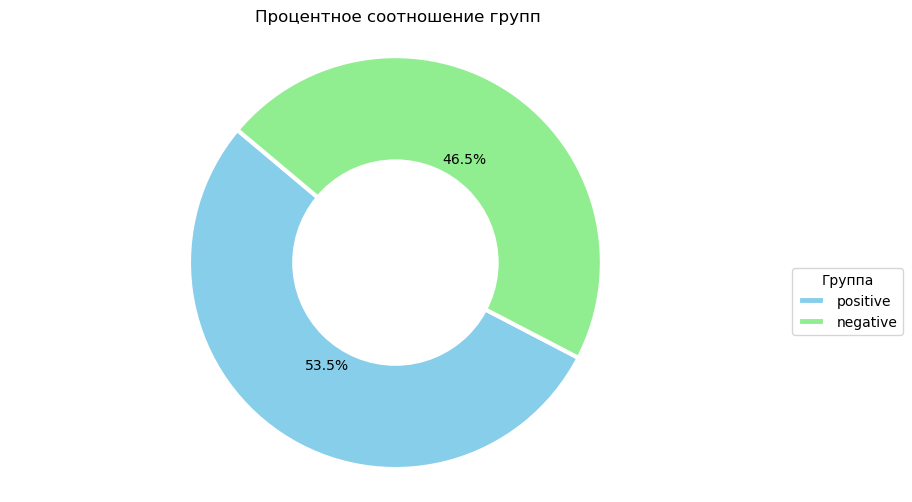

In [35]:
# Создадим круговую диаграмму
plt.figure(figsize=(10, 6))

wedges, texts, autotexts = plt.pie(
    sizes,
    labels=None,  
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
    textprops={'color': 'black'}
)
plt.axis('equal')

# Добавление белого круга внутри
center_circle = plt.Circle((0, 0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Создание легенды и добавление названий секторов в легенду
plt.legend(labels, title='Группа', loc='upper left', bbox_to_anchor=(1, 0.5))

plt.title('Процентное соотношение групп')
plt.show()